# Actual Arrival Delay Prediction

## Data Srotytelling

Travelers create flight itineraries at different times, often involving direct flights or multiple connections across various airports and flights operated by one or more airlines. Airlines and airports possibly experience different rates of cancellations and delays, which vary by time of day, season, weather conditions, and traffic levels. Additionally, travelers may have either strict or flexible arrival time requirements, and they may wish to assess the likelihood of arriving at a specific time or the potential delay duration with a certain level of confidence.

How can travelers predict the likelihood and duration of flight delays with a specified level of accuracy to meet specific arrival time requirements?

The US Domestic Flights Delay (2013-2018) dataset includes scheduled and actual departure and arrival times. The data, collected by the U.S. Office of Airline Information, Bureau of Transportation Statistics (BTS), covers flights between 2014 and 2018 and includes details such as date, time, origin, destination, airline, distance, and delay status. (Source: [Kaggle](https://www.kaggle.com/datasets/gabrielluizone/us-domestic-flights-delay-prediction-2013-2018))

Several hypotheses suggest factors that may influence arrival delay:

1.	Airports vary in capacity and traffic, with some being busier than others.
2.	Seasonal variations throughout the year may affect both the likelihood and duration of delays.
3.	Different days of the week may have varying levels of flight load, potentially impacting arrival delays.
4.	Time of day influences traffic levels, leading to fluctuations in delays across different periods.
5.	The efficiency of airlines and airports in processing traffic and managing flights can impact their ability to adhere to schedules.

### Loading packages and data

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import scipy.stats as st

input_file_name = '../data/processed/processed_2014_2018_final.pickle'
with open(input_file_name, 'rb') as in_file:
    flights = pickle.load(in_file)

### Assessing Flight Shares and Clustering Airports

In [34]:
print('Number of unique airports - {}'.format(flights['Origin'].nunique()))

Number of unique airports - 368


In [35]:
number_of_flights = flights.groupby('Origin', observed=False)[['CRSDepDT']].count().sort_values(by='CRSDepDT', ascending=False)
number_of_flights['Share'] = number_of_flights['CRSDepDT'] / np.sum(number_of_flights['CRSDepDT'])
number_of_flights['Cum_share'] = number_of_flights['Share'].cumsum()
main_airports = list(number_of_flights[number_of_flights['Cum_share'] <= .8].index)
print('Number of airports fullfilled 80% of flights {:,d}'.format(len(main_airports)))

Number of airports fullfilled 80% of flights 47


There are 368 airports included in this report, with 80% of all domestic flights operated through just 47 of them. This indicates that the load across airports is uneven, with some airports being significantly busier than others. We will designate these 47 airports as “Major” and the remaining ones as “Minor” and will use this feature in our analysis. 

In [36]:
flights['OriginStatus'] = 'Minor'
flights.loc[flights['Origin'].isin(main_airports), 'OriginStatus'] = 'Major'
flights['OriginStatus'] = flights['OriginStatus'].astype('category')

In [37]:
# number_of_flights['Load'] = pd.qcut(number_of_flights['CRSDepDT'], 3, labels=['low', 'middle', 'high'])
# number_of_flights['Status'] = 'Minor'
# number_of_flights.loc[main_airports, 'Status'] = 'Major'

## Seasonal Variations Throughout the Year

At first glance, the graph below shows a seasonal variation in flight delays throughout the year. Arrival delays for flights from both Major and Minor airports are higher during the summer months, as well as in December and January. n contrast, flight delays are much lower in autumn. This pattern appears consistent for both Major and Minor airports.

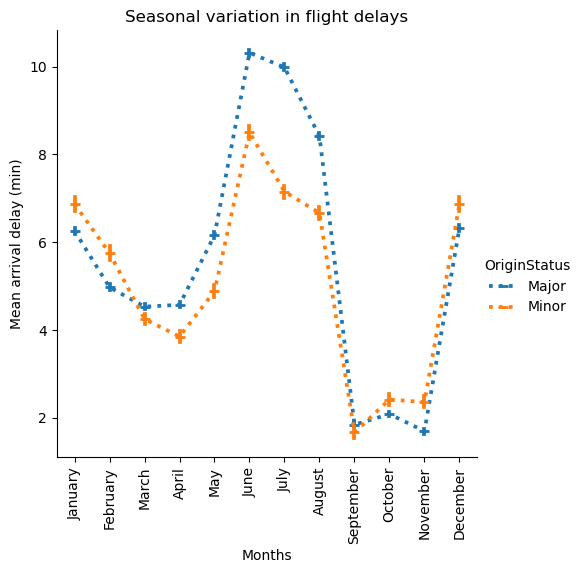

In [38]:
ax = sns.catplot(x = 'Month', 
            y = 'ActArrDelay', 
            data = flights, 
            hue = 'OriginStatus', 
            kind = 'point', 
            marker = '_',
            linestyle = ':')
ax.set(xlabel='Months',
       ylabel='Mean arrival delay (min)',
       title='Seasonal variation in flight delays')
ax.set_xticklabels(labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], 
                   rotation = 90)


However, the Chi-square test indicates that these differences are not statistically significant at a 5% significance level for both Major and Minor airports, with p-values of 10.8% and 48.2%, respectively. In other words, we cannot reject the null hypothesis that the mean arrival delay is the same across all months.

In [39]:
chisq, p = st.chisquare(flights[flights['OriginStatus'] == 'Major'].groupby('Month')['ActArrDelay'].mean())
print('The Chi-square for month delay means at major airports is {:.3f}, with P-value of {:.3f}'.format(chisq, p))
chisq, p = st.chisquare(flights[flights['OriginStatus'] == 'Minor'].groupby('Month')['ActArrDelay'].mean())
print('The Chi-square for month delay means at minor airports is {:.3f}, with P-value of {:.3f}'.format(chisq, p))

The Chi-square for month delay means at major airports is 16.984, with P-value of 0.108
The Chi-square for month delay means at minor airports is 10.544, with P-value of 0.482


For weekdays, the situation appears similar: the graph shows variation in mean arrival delays across the weekdays, but the Chi-square test indicates that these differences are not statistically significant at the 5% level (with p-values of 77.1% for Major airports and 92.7% for Minor airports).

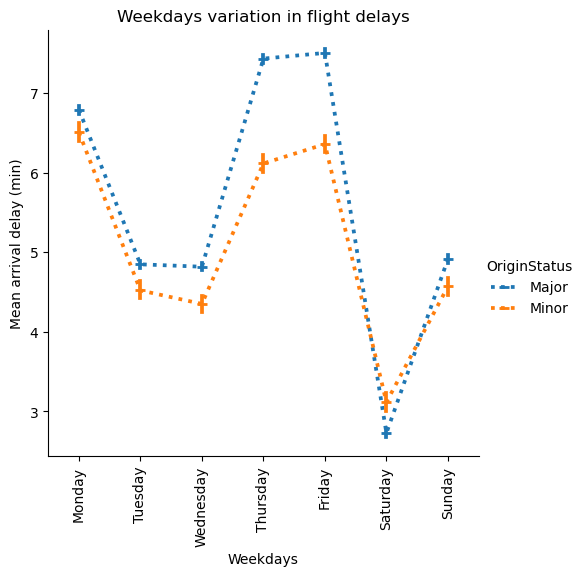

In [40]:
ax = sns.catplot(x = 'Weekday', 
            y = 'ActArrDelay', 
            data = flights, 
            hue = 'OriginStatus', 
            kind = 'point', 
            marker = '_',
            linestyle = ':');
ax.set(xlabel='Weekdays',
       ylabel='Mean arrival delay (min)',
       title='Weekdays variation in flight delays');
ax.set_xticklabels(labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                   rotation = 90);

In [41]:
chisq, p = st.chisquare(flights[flights['OriginStatus'] == 'Major'].groupby('Weekday')['ActArrDelay'].mean())
print('The Chi-square for weekday delay means at major airports is {:.3f}, with P-value of {:.3f}'.format(chisq, p))
chisq, p = st.chisquare(flights[flights['OriginStatus'] == 'Minor'].groupby('Weekday')['ActArrDelay'].mean())
print('The Chi-square for weekday delay means at minor airports is {:.3f}, with P-value of {:.3f}'.format(chisq, p))

The Chi-square for weekday delay means at major airports is 3.281, with P-value of 0.773
The Chi-square for weekday delay means at minor airports is 1.913, with P-value of 0.928


__Conclusion:__ Despite observing variations in mean arrival delays in the graphs above, hypothesis testing does not allow us to reject the null hypothesis: there is no statistically significant difference in mean arrival delays between weekdays or months.

## Reasons for Delays Across Different Months, Airports, and Airlines

The US Domestic Flights Delay dataset contains a breakdown of departure delays for each delayed flight. It is interesting to examine the components of these delays and their variation across months, airports (both Origin and Destination), and airlines. We will analyze the following features:

*	Actual Arrival Delay (ActArrDelay)
*	Carrier Delay (CarrierDelay)
*   Weather Delay (WeatherDelay)
*	National Air System Delay (NASDelay)
*	Security Delay (SecurityDelay)
*	Late Aircraft Delay (LateAircraftDelay)

In [42]:
# The list of features to examine
columns_of_interest = ['ActArrDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay','LateAircraftDelay', 'SecurityDelay']

Again, we see from the results below that none of the features show a statistically significant variation across months at a 5% significance level. This aligns with the previous analysis of actual arrival delays across months.

In [43]:
# The Chi-square test for statistical segnificance of the features variation across months
for col in columns_of_interest:
    mean_delay = flights.groupby('Month', observed=False)[[col]].mean()
    chisq, p = st.chisquare(mean_delay[col])
    print('{} delay chi-square = {:.3f}, P-value = {:.3f}'.format(col, chisq, p))

ActArrDelay delay chi-square = 15.303, P-value = 0.169
CarrierDelay delay chi-square = 0.151, P-value = 1.000
WeatherDelay delay chi-square = 1.337, P-value = 1.000
NASDelay delay chi-square = 0.408, P-value = 1.000
LateAircraftDelay delay chi-square = 1.694, P-value = 0.999
SecurityDelay delay chi-square = 0.061, P-value = 1.000


However, the results below indicate that two aspects (features) exhibit a statistically significant variation at a 5% significance level across airlines: Actual Arrival Delays (ActArrDelay) with a p-value of 1.5% and National Air System Delay (NASDelay) with a p-value of 0%. The two graphs below represents these variations.

In [44]:
# The Chi-square test for statistical segnificance of the features variation across Airlines
for col in columns_of_interest:
    mean_delay = flights.groupby('Reporting_Airline', observed=False)[[col]].mean()
    chisq, p = st.chisquare(mean_delay[col])
    print('{} delay chi-square = {:.3f}, P-value = {:.3f}'.format(col, chisq, p))

ActArrDelay delay chi-square = 34.573, P-value = 0.016
CarrierDelay delay chi-square = 24.864, P-value = 0.165
WeatherDelay delay chi-square = 16.108, P-value = 0.650
NASDelay delay chi-square = 57.270, P-value = 0.000
LateAircraftDelay delay chi-square = 27.557, P-value = 0.092
SecurityDelay delay chi-square = 1.012, P-value = 1.000


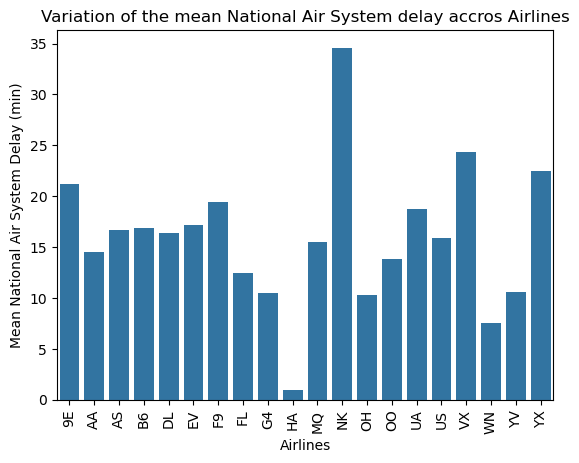

In [45]:
df = flights.groupby('Reporting_Airline', observed=False)[['NASDelay']].mean()
ax = sns.barplot(x = 'Reporting_Airline', 
            y = 'NASDelay', 
            data = df)
ax.set(xlabel='Airlines',
       ylabel='Mean National Air System Delay (min)',
       title='Variation of the mean National Air System delay accros Airlines')
ax.set_xticks(df.index)
ax.set_xticklabels(df.index, rotation = 90);

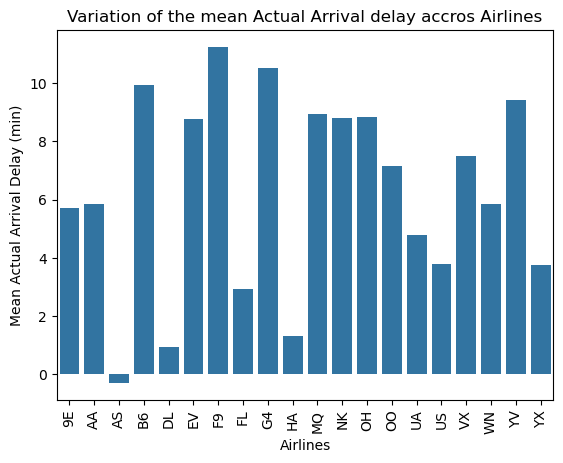

In [46]:
df = flights.groupby('Reporting_Airline', observed=False)[['ActArrDelay']].mean()
ax = sns.barplot(x = 'Reporting_Airline', 
            y = 'ActArrDelay', 
            data = df)
ax.set(xlabel='Airlines',
       ylabel='Mean Actual Arrival Delay (min)',
       title='Variation of the mean Actual Arrival delay accros Airlines')
ax.set_xticks(df.index)
ax.set_xticklabels(df.index, rotation = 90);

The analysis of the variation in means of our features shows a strong statistical significance (with p-values equal 0) in these variations across the airports of Origin and Destination, except for the variation in Security Delays (SecurityDelay) across Destination airports, which is reasonable because security checks occur only at the Origin airport.

Due to our primary interest in Actual Arrival Delay, I have included below two graphs depicting the Variation of Actual Arrival Delay across Origin and Destination airports. All other reasons for delays are included and contribute to the Actual Arrival Delay.

In [47]:
# The Chi-square test for statistical segnificance of the features variation across Origin Airports
print('Origin airports\n---------------')
for col in columns_of_interest:
    mean_delay = flights.groupby('Origin', observed=False)[[col]].mean()
    mean_delay = mean_delay[~mean_delay[col].isna()]
    chisq, p = st.chisquare(mean_delay[col])
    print('{} delay chi-square = {:.3f}, P-value = {:.3f}'.format(col, chisq, p))

Origin airports
---------------
ActArrDelay delay chi-square = 2458.958, P-value = 0.000
CarrierDelay delay chi-square = 1426.988, P-value = 0.000
WeatherDelay delay chi-square = 1414.634, P-value = 0.000
NASDelay delay chi-square = 1055.986, P-value = 0.000
LateAircraftDelay delay chi-square = 983.920, P-value = 0.000
SecurityDelay delay chi-square = 2333.580, P-value = 0.000


In [48]:
# The Chi-square test for statistical segnificance of the features variation across Destination Airports
print('Destination airports\n--------------------')
for col in columns_of_interest:
    mean_delay = flights.groupby('Dest', observed=False)[[col]].mean()
    mean_delay = mean_delay[~mean_delay[col].isna()]
    chisq, p = st.chisquare(mean_delay[col])
    print('{} delay chi-square = {:.3f}, P-value = {:.3f}'.format(col, chisq, p))

Destination airports
--------------------
ActArrDelay delay chi-square = 1702.477, P-value = 0.000
CarrierDelay delay chi-square = 742.052, P-value = 0.000
WeatherDelay delay chi-square = 1619.137, P-value = 0.000
NASDelay delay chi-square = 710.910, P-value = 0.000
LateAircraftDelay delay chi-square = 760.294, P-value = 0.000
SecurityDelay delay chi-square = 57.242, P-value = 1.000


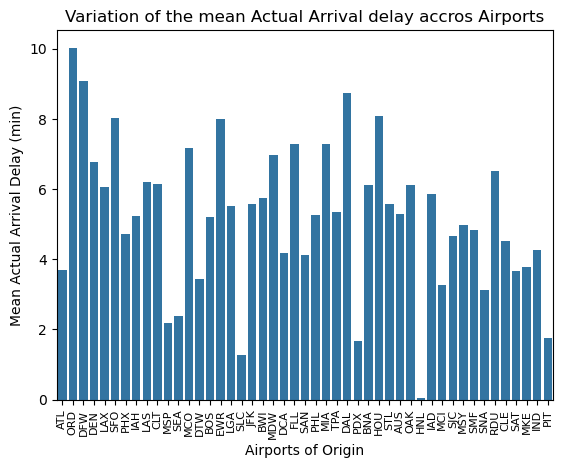

In [49]:
main_origin = flights.groupby('Origin', observed=False)[['ActArrDelay']].mean().loc[main_airports, :]
main_origin = main_origin.reset_index()
main_origin['Origin'] = main_origin['Origin'].astype('object')
ax = sns.barplot(x = 'Origin', 
                 y = 'ActArrDelay', 
                 data = main_origin)
ax.set(xlabel='Airports of Origin',
       ylabel='Mean Actual Arrival Delay (min)',
       title='Variation of the mean Actual Arrival delay accros Airports')
ax.set_xticks(main_origin['Origin'])
ax.set_xticklabels(main_origin['Origin'], rotation=90, size = 8);

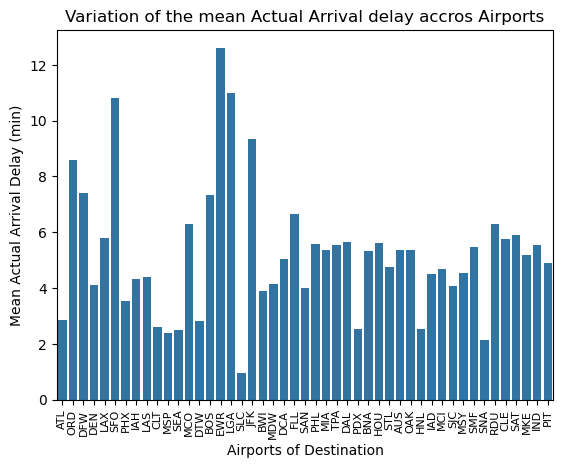

In [50]:
main_dest = flights.groupby('Dest', observed=False)[['ActArrDelay']].mean().loc[main_airports, :]
main_dest = main_dest.reset_index()
main_dest['Dest'] = main_dest['Dest'].astype('object')
ax = sns.barplot(x = 'Dest', 
                 y = 'ActArrDelay', 
                 data = main_dest)
ax.set(xlabel='Airports of Destination',
       ylabel='Mean Actual Arrival Delay (min)',
       title='Variation of the mean Actual Arrival delay accros Airports')
ax.set_xticks(main_dest['Dest'])
ax.set_xticklabels(main_dest['Dest'], rotation=90, size = 8);

__Conclusion:__ The mean Actual Arrival Delay exhibits a statistically significant variation at a 5% significance level across airports and airlines.

## Analysis of the Departure and Arrival Time Blocks 

The US Domestic Flights Delay dataset contains information about time blocks for Departure and Arrival. These blocks are represented by the following categorical values: the first time block includes 6 hours from 00:01 to 05:59, while the remaining 18 blocks each cover 1 hour (for example, 06:00 - 06:59, 07:00 - 07:59, etc.).

In the next section, we will analyze whether there is an association between the time blocks of departure and arrival and Actual Arrival Delay, as well as other components of delay. In other words, we will examine whether there is any relationship between the time of Departure/Arrival and delays.

The chi-square tests below indicate a statistically significant relationship between Departure or Arrival Time Blocks and Actual Arrival Delay, Carrier Delay, and Late Aircraft Delay. A possible explanation for these relationships could be the existence of rush hours for airports and airlines, during which their ability to service all flights on time decreases.

In [51]:
# The Chi-square test for statistical segnificance of the features variation across Departure Time Blocks
print('Departure Time blocks\n---------------------')
for col in columns_of_interest:
    mean_delay = flights.groupby('DepTimeBlk', observed=False)[[col]].mean()
    chisq, p = st.chisquare(mean_delay[col])
    print('{} delay chi-square = {:.3f}, P-value = {:.3f}'.format(col, chisq, p))

Departure Time blocks
---------------------
ActArrDelay delay chi-square = 73.052, P-value = 0.000
CarrierDelay delay chi-square = 48.421, P-value = 0.000
WeatherDelay delay chi-square = 3.615, P-value = 1.000
NASDelay delay chi-square = 14.278, P-value = 0.711
LateAircraftDelay delay chi-square = 59.829, P-value = 0.000
SecurityDelay delay chi-square = 0.268, P-value = 1.000


In [52]:
# The Chi-square test for statistical segnificance of the features variation across Arrival Time Blocks
print('Arrival Time blocks\n-------------------')

for col in columns_of_interest:
    mean_delay = flights.groupby('ArrTimeBlk', observed=False)[[col]].mean()
    chisq, p = st.chisquare(mean_delay[col])
    print('{} delay chi-square = {:.3f}, P-value = {:.3f}'.format(col, chisq, p))

Arrival Time blocks
-------------------
ActArrDelay delay chi-square = 76.741, P-value = 0.000
CarrierDelay delay chi-square = 46.949, P-value = 0.000
WeatherDelay delay chi-square = 3.549, P-value = 1.000
NASDelay delay chi-square = 8.803, P-value = 0.964
LateAircraftDelay delay chi-square = 56.787, P-value = 0.000
SecurityDelay delay chi-square = 0.251, P-value = 1.000


Let’s examine these relationships visually.

In the two graphs below, we observe clear relationships between Actual Arrival Time and Time Blocks of Departure/Arrival. I believe that a relationship exists just between Actual Arrival Time and Departure Time Block, as Arrival Time Block is simply a function of Departure Time Block and flight duration.

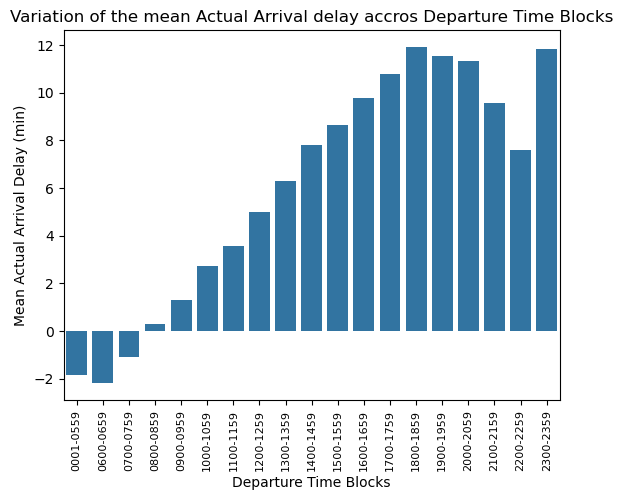

In [53]:
main_dest = flights.groupby('DepTimeBlk', observed=False)[['ActArrDelay']].mean()
main_dest = main_dest.reset_index()
ax = sns.barplot(x = 'DepTimeBlk', y = 'ActArrDelay', data = main_dest)
ax.set(xlabel='Departure Time Blocks',
       ylabel='Mean Actual Arrival Delay (min)',
       title='Variation of the mean Actual Arrival delay accros Departure Time Blocks')
plt.xticks(rotation=90, size = 8)
plt.show()

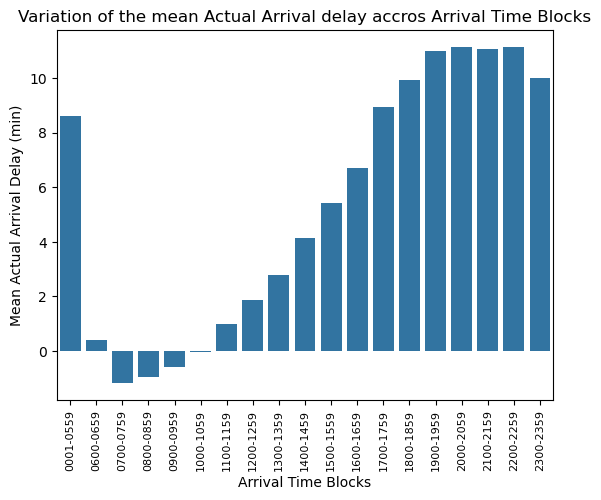

In [54]:
main_dest = flights.groupby('ArrTimeBlk', observed=False)[['ActArrDelay']].mean()
main_dest = main_dest.reset_index()
ax = sns.barplot(x = 'ArrTimeBlk', y = 'ActArrDelay', data = main_dest)
ax.set(xlabel='Arrival Time Blocks',
       ylabel='Mean Actual Arrival Delay (min)',
       title='Variation of the mean Actual Arrival delay accros Arrival Time Blocks')
plt.xticks(rotation=90, size = 8)
plt.show()

__Conclusion:__ The graphs and Chi-square tests confirm a strong relationship between Actual Arrival Delay and the time blocks of departure and arrival.

## Flights That Haven’t Reached Their Destination (Cancelled or Diverted to a Different Location)

We have examined the relationships between Actual Arrival Delay and various factors that may cause or influence flight delays. However, aside from delays, there is another unfavorable outcome for passengers: flights that were cancelled or diverted to a different location, meaning passengers did not reach their final destination on that flight.

According to the US Domestic Flights Delay data, 1.65% of flights experienced this outcome. Analysis of the relationships between this outcome and flight period (Month, Weekday), Airline, and Airport below reveals no statistically significant relationships between these features and the rate of flights not reaching their destination.

In [55]:
print('Share of flights not reached Destinaiotion (cancelled or finished in a different airport) {:.2%}'.format(1 - flights['ReachedDest'].mean()))

Share of flights not reached Destinaiotion (cancelled or finished in a different airport) 1.65%


In [56]:
groups_list = ['Month' ,'Weekday', 'Reporting_Airline', 'Origin', 'Dest', 'DepTimeBlk', 'ArrTimeBlk']

In [57]:
for gr in groups_list:
    ReachedDest_rate = flights.groupby(by=gr, observed=False)[['ReachedDest']].mean()
    ReachedDest_rate = ReachedDest_rate[~ReachedDest_rate['ReachedDest'].isna()]
    chisq, p = st.chisquare(ReachedDest_rate['ReachedDest'])
    print('{} not reaching destination rate Chi-square = {:.3f}, P-Value = {:.3f}'.format(gr, chisq, p))

Month not reaching destination rate Chi-square = 0.001, P-Value = 1.000
Weekday not reaching destination rate Chi-square = 0.000, P-Value = 1.000
Reporting_Airline not reaching destination rate Chi-square = 0.003, P-Value = 1.000
Origin not reaching destination rate Chi-square = 1.119, P-Value = 1.000
Dest not reaching destination rate Chi-square = 0.134, P-Value = 1.000
DepTimeBlk not reaching destination rate Chi-square = 0.000, P-Value = 1.000
ArrTimeBlk not reaching destination rate Chi-square = 0.000, P-Value = 1.000


__Conclusion:__ The analysis of the rate of flights not reaching their destination does not reveal any relationship with time periods, like months, weekdays or departure/arrival time blocks.

## Other Relationships

The analysis of additional factors, shown below, does not reveal any particularly useful relationships, as it mainly identifies correlations (some of them quite strong) between Actual Arrival Delay and factors such as Actual Elapsed Time for diverted flights and arrival delay at the alternate destination. These factors cannot be used as predictors in our model because they are not known in advance (at the time of trip planning) and therefore cannot serve as inputs.

All independent variables in our model are represented by categorical variables, which makes it impossible to calculate correlations among them or between them and the dependent variable, Actual Arrival Delay.

In [58]:
columns_of_interest = ['Reporting_Airline',
                       # 'Origin',
                       # 'Dest',
                       # 'DepTimeBlk',
                       # 'ArrTimeBlk',
                       'AirTime',
                       # 'CarrierDelay',
                       # 'WeatherDelay',
                       # 'NASDelay',
                       # 'SecurityDelay',
                       # 'LateAircraftDelay',
                       'DivActualElapsedTime',
                       'DivArrDelay',
                       'CRSDep_UTC',
                       'CRSArr_UTC',
                       # 'ActDep_UTC',
                       # 'ActArr_UTC',
                       'ActArrDelay',
                       'Weekday',
                       'Month',
                       'OriginStatus']

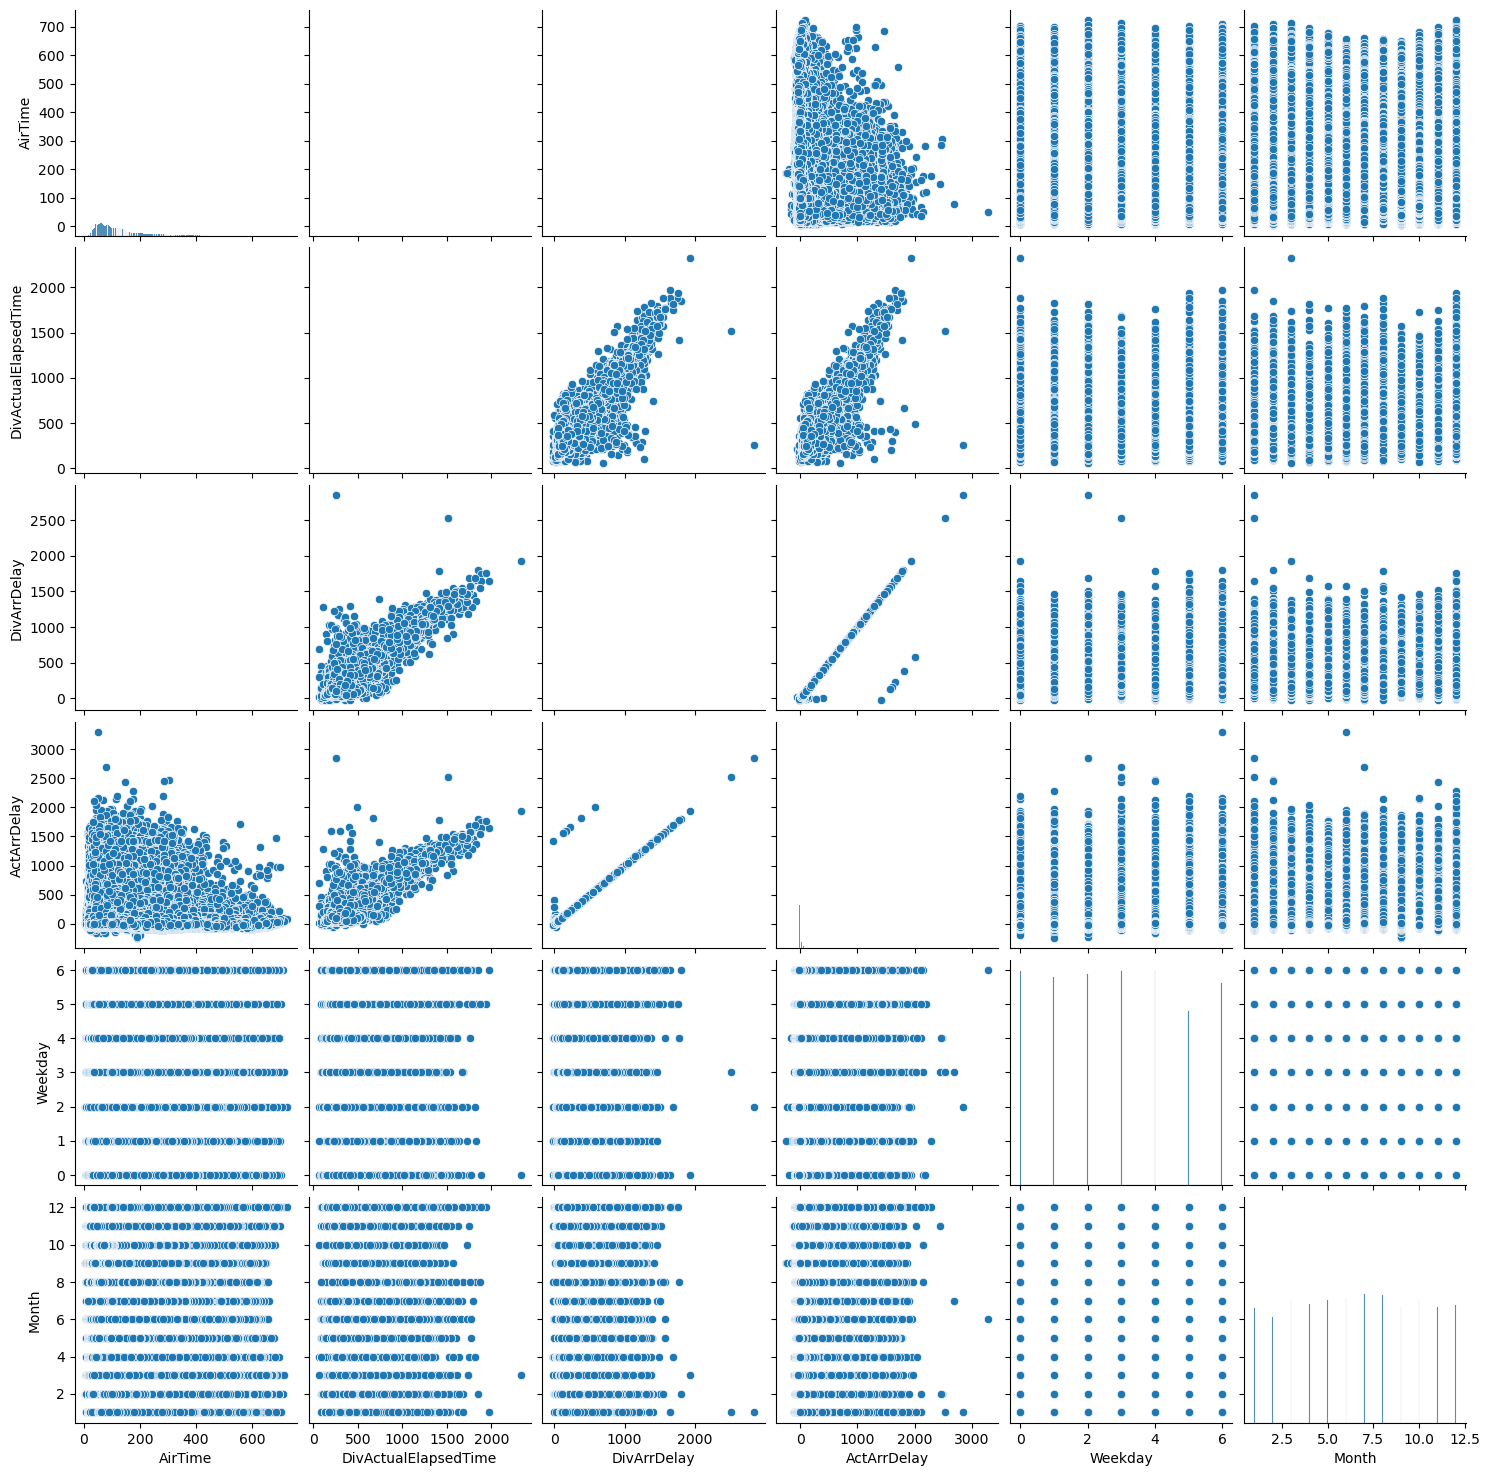

In [59]:
sns.pairplot(flights[columns_of_interest])
plt.show()

__Conclusion:__ The remaining factors, such as Actual Elapsed Time and Arrival Delay for diverted flights, have no predictive value for the model because they cannot be anticipated when planning an itinerary.

## Data Transformation

The graph below shows that our dependent variable (ActArrDelay) is right-skewed, and the Kolmogorov-Smirnov test for normality confirms this lack of fit (p-value = 0). Unfortunately, transforming the dependent variable by taking the logarithm of Actual Arrival Delay (shifted by its minimum value) did not yield any improvement, as the p-value of the Kolmogorov-Smirnov test remains zero. This indicates that the transformed data is still skewed and does not fit a normal distribution.

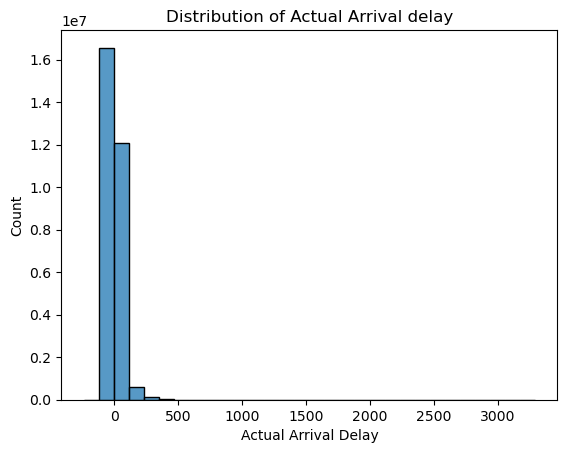

In [60]:
ax = sns.histplot(flights['ActArrDelay'], bins=30)
ax.set(xlabel='Actual Arrival Delay',
       ylabel='Count',
       title='Distribution of Actual Arrival delay')
plt.show()

In [61]:
shift = - np.floor(min(flights['ActArrDelay']) / 100) * 100
flights['shiftedActArrDelay'] = flights['ActArrDelay'] + shift
logActArr = np.log(flights['shiftedActArrDelay'])
st.kstest(logActArr[~logActArr.isna()], st.norm.cdf)

KstestResult(statistic=0.9999995561154857, pvalue=0.0, statistic_location=5.19295685089021, statistic_sign=-1)

## Conclusions:

1.	Although we observed apparent variations in mean Actual Arrival Delays across months and weekdays in the graphs, hypothesis testing did not allow us to reject the null hypothesis: there is no statistically significant difference in mean Actual Arrival Delays between weekdays or months. 

2.	Chi-square tests confirmed a statistically significant variation in mean Actual Arrival Delay across different airports and airlines at a 5% significance level, which was also illustrated visually in the graphs.  

3.	Both the graphs and Chi-square tests indicate a strong relationship between Actual Arrival Delay and the time blocks of departure and arrival.  

4.	Analysis of the rate of flights not reaching their destination shows no relationship with flight timing (month, weekday, or departure/arrival time blocks), airport, or airline.  

5.	Remaining factors, such as Actual Elapsed Time and Arrival Delay for diverted flights, hold no predictive value for the model, as these factors cannot be anticipated when planning an itinerary.  

6.	The target variable, Actual Arrival Delay (ActArrDelay), is right-skewed and does not fit a normal distribution, as confirmed by the Kolmogorov-Smirnov test. Applying a logarithmic transformation did not improve the distribution.  

7.	All independent variables identified as having a relationship with the target variable, Actual Arrival Delay, are categorical and must be handled accordingly in the model design phase.